# Exercise 06 CNN for Image Classification - Instruction

## Pedagogy

This notebook serves as an instruction for implementing CNNs using PyTorch to develop image classification models.

Please use this notebook as a reference and guide to complete the assignment.

### Import libraries

In this notebook we will use several new libraries:
- `os` for managing the saved file of the trained model
- `datetime` for getting time and calculate time consumed by training
- `trochvision.datasets` for obtaining PyTorch built-in datasets
- `torchvision.transforms` for data preprocessing using PyTorch built-in transform functions
- `torchvision.utils.data.random_split` for splitting datasets like `sklearn.model_selection.train_test_split`

In [1]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets as sklearn_datasets
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

In [2]:
# suppress all warnings
warnings.filterwarnings("ignore")

## Part 1. Hand-written Digits Recognition with CNN

In this part, we will build a multi-class image classifier using CNN.

The problem to be solved is to recognize the hand-written digits:

![](https://jamesmccaffrey.files.wordpress.com/2020/10/uci_digits_0_to_9-1.jpg)

We will use the `sklearn` built-in hand-written digits dataset in this part.
- Each hand-written digit image contains $8\times8$ pixels with only one channel.
- There are 10 classes, where each class refers to one digit.
- There are about 180 samples per class, 1797 samples in total.

We will first use this small dataset to illustrate how to implement a CNN. Then we will move to a large dataset (70,000 samples) in the next part.

### Step 1. Build the data pipeline

In this step, we need to:
- Use `sklearn.datasets.load_digits()` to load the hand-written digits dataset
- Pre-process the dataset
    - Scale numerical features with `sklearn.preprocessing.MinMaxScaler`
    - `torch.nn.CrossEntropyLoss` implements internal one-hot encoding, no need to encode categorical labels yourself
- Divide the dataset into the training, valiation, and test set
- Create `TensorDataset` instances to store the dataset
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [3]:
# load the dataset
feature, label = sklearn_datasets.load_digits(
    return_X_y = True,
    as_frame = False, # get data as numpy array
)

In [4]:
# feature scaling
scaler = MinMaxScaler()
scaled_feature = scaler.fit_transform(feature)

In [5]:
# Split the dataset into train, validation, and test sets
train_val_feature, test_feature, train_val_label, test_label = train_test_split(
    scaled_feature, label, test_size = 0.2, random_state = 0
)
train_feature, val_feature, train_label, val_label = train_test_split(
    train_val_feature, train_val_label, test_size = 0.25, random_state = 0
)

In [6]:
# create the train, validatoin, and test dataset
# specify the type of data stored in the tensors to avoid incompatiblity
train_ds = TensorDataset(
    torch.tensor(train_feature.reshape(-1, 1, 8, 8), dtype = torch.float32),
    torch.tensor(train_label, dtype = torch.long)
)
val_ds = TensorDataset(
    torch.tensor(val_feature.reshape(-1, 1, 8, 8), dtype = torch.float32),
    torch.tensor(val_label, dtype = torch.long)
)
test_ds = TensorDataset(
    torch.tensor(test_feature.reshape(-1, 1, 8, 8), dtype = torch.float32),
    torch.tensor(test_label, dtype = torch.long)
)

In [7]:
# create the train and test data loaders
batch_size = 256 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

In [8]:
# display the dimensionality of a batch
for (X, y) in val_dl:
    print('Feature shape:', X.shape)
    print('Label shape:', y.shape)
    break

Feature shape: torch.Size([256, 1, 8, 8])
Label shape: torch.Size([256])


We can see the shape (batch_size, channels, height, width) of a batch of features is:
- batch_size = 256, there are 256 samples in one batch
- channels = 1, there are only one channel (grascale image)
- height = 8, width = 8, theere are $8\times8$ pixels in one image

The shape (batch_size) of a batch of labels is:
- batch_size = 256, there are 256 samples in one batch

The label of this hand-written digit is: 6


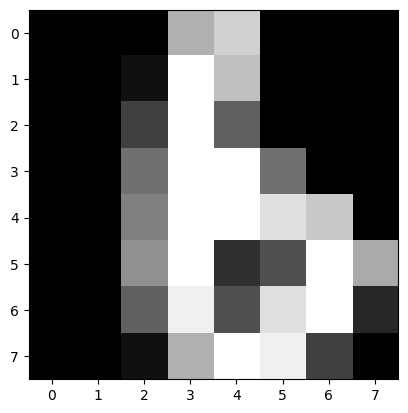

In [9]:
# display an example
plt.imshow(train_ds[0][0].numpy().reshape(8, 8), cmap = 'gray')
print('The label of this hand-written digit is:', train_ds[0][1].item())

### Step 2. Create a CNN image classifier

In this step, we will create a CNN image classifier. To do this, we need to:
- Specify the network structure and the forward method by defining a custom class
- Specify the device used for computation
    - `cpu`
    - `mps` for MacOS with Apple Silicon
    - `cuda` for Windows/Linux with Nvidia GPU (support CUDA)
- Invoke the custom class to create an instance of CNN

In [11]:
# define a custom neural network class
class ImageClassifier(nn.Module):
    def __init__(self, in_channels, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels = 3, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.LazyConv2d(out_channels = 9, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.LazyConv2d(out_channels = 27, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.Flatten(),
            nn.LazyLinear(1000), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
            nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
            nn.LazyLinear(10)
        )

    def forward(self, x):
        return self.net(x)

We can see we defined a multi-layer CNN with 3 convolutional layers and 3 fully connected layers.
- Use `nn.Lazy...` to avoid calculating the input size yourself:
    - Use `nn.LazyConv2d` instead of `nn.Conv2d`
    - Use `nn.LazyBatchNorm2d` instead of `nn.BatchNorm2d`
    - Use `nn.LazyLinear` instead of `nn.Linear`
- Batch normalization layer is positioned before the activation function layer
- Pooling layer is positioned after the activation function layer
- Use `nn.Flatten` to flatten the 2D feature map into 1D feature vector
- Dropout layer is positioned after the activation function layer and only between fully connected layers
    - You can also add `nn.Dropout2d` between convolutional layers, which will randomly drop out the entire channel of the input feature map

In [12]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [13]:
# create the neural network
model = ImageClassifier(
    in_channels = train_ds[0][0].shape[0],
    n_labels = 10
).to(device)

We invoke `.to(device)` after creating the CNN instance.

The default device for newly created network is CPU.

We use `.to(device)` to move the network from CPU to GPU if `mps` or `cuda` is available.

### Step 3. Train the network

In this step, we will train the previously created CNN.
We first define a `train()` function to perform the training process, which is slightly different from the previous session:
- The code is optimized for readability
    - The detailed comments after each line is removed
    - Some operations are aggregated into one-line operation
- Model saving operation is embedded into the training process
    - Automatic saving when achieving a better validation loss
    - Return `saved_path` when the training process is finished for reloading the best model
- Count and pring the time consumed by training after each epoch
- The data batch is also moved to GPU if it's available.

After defining the `train()` function, we can continue to
- Specify the training hyper-paramters
- Implement the training process
- Reload the best model saved during the training process
- Visualize the loss history

In [14]:
# define the training function
def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, early_stopping_patience, lr_scheduler):
    # initialization
    min_val_loss, patience_counter = np.inf, 0
    saved_path, start_time = '', datetime.datetime.now()
    # aggregate loss histories into a dictionary
    histories = {'train_batch': [], 'train_epoch': [], 'val_batch': [], 'val_epoch': []}

    for epoch in range(epochs):
        # train
        model.train()
        train_epoch_loss = 0.0
        for X, y in train_dl:
            X, y = X.to(device), y.to(device) # move data to GPU
            optimizer.zero_grad()
            train_batch_loss = loss_fn(model(X), y)
            train_batch_loss.backward()
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
            histories['train_batch'].append(train_batch_loss.item())
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(device), y.to(device) # move data to GPU
                val_batch_loss = loss_fn(model(X), y)
                val_epoch_loss += val_batch_loss.item()
                histories['val_batch'].append(val_batch_loss.item())
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        if current_lr != optimizer.param_groups[0]['lr']:
            print(f'Learning rate reduced after epoch {epoch+1}')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss, patience_counter = val_epoch_loss, 0
            # save the current model as a new minimal validation loss is achieved
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = end_time.strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = f'epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping!')
                break
                
    return histories, saved_path

In [15]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 20
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)

In [16]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
model.load_state_dict(torch.load(saved_path))

Epoch 1: train loss = 1.998790, val loss = 2.291905, time consumed = 0:00:00
Model saved after epoch 1
Epoch 2: train loss = 1.363549, val loss = 2.285992, time consumed = 0:00:00
Model saved after epoch 2
Epoch 3: train loss = 1.070165, val loss = 2.191270, time consumed = 0:00:00
Model saved after epoch 3
Epoch 4: train loss = 0.870144, val loss = 1.901864, time consumed = 0:00:00
Model saved after epoch 4
Epoch 5: train loss = 0.716772, val loss = 1.420153, time consumed = 0:00:00
Model saved after epoch 5
Epoch 6: train loss = 0.581317, val loss = 1.114710, time consumed = 0:00:01
Model saved after epoch 6
Epoch 7: train loss = 0.554428, val loss = 1.170876, time consumed = 0:00:01
Epoch 8: train loss = 0.433561, val loss = 0.441857, time consumed = 0:00:01
Model saved after epoch 8
Epoch 9: train loss = 0.406511, val loss = 0.819369, time consumed = 0:00:01
Epoch 10: train loss = 0.355302, val loss = 0.357591, time consumed = 0:00:01
Model saved after epoch 10
Epoch 11: train loss

<All keys matched successfully>

We can see we reload the best model saved during the training process.

This is because training will continue for several epochs (according to the early stopping patience) after the last saving.

The model after training is not the best model we saved during training. We need to reload the best one.

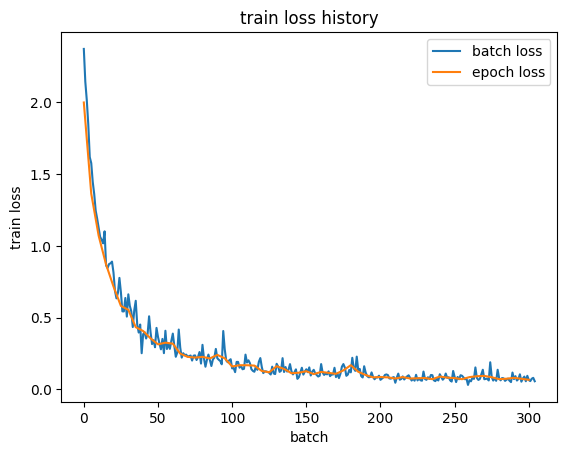

In [17]:
# plot the train loss history
plt.figure()
batch = np.arange(len(histories['train_batch']))
epoch = np.arange(len(histories['train_epoch']))
batches_per_epoch = (int(len(train_ds) / batch_size + 1))
plt.plot(batch, histories['train_batch'], '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, histories['train_epoch'], '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

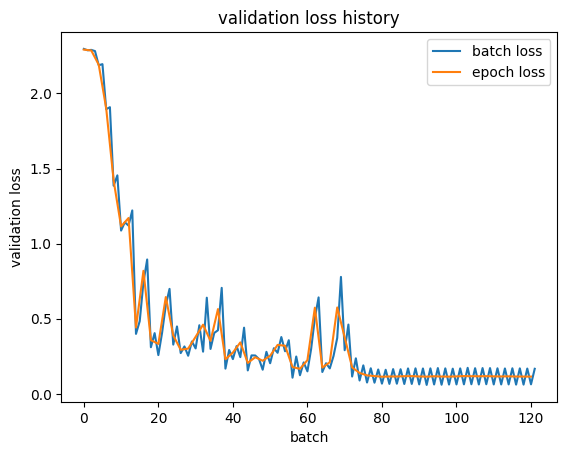

In [18]:
# plot the train loss history
plt.figure()
batch = np.arange(len(histories['val_batch']))
epoch = np.arange(len(histories['val_epoch']))
batches_per_epoch = (int(len(val_ds) / batch_size + 1))
plt.plot(batch, histories['val_batch'], '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, histories['val_epoch'], '-', label = 'epoch loss')
plt.title('validation loss history')
plt.xlabel('batch')
plt.ylabel('validation loss')
plt.legend()
plt.show()

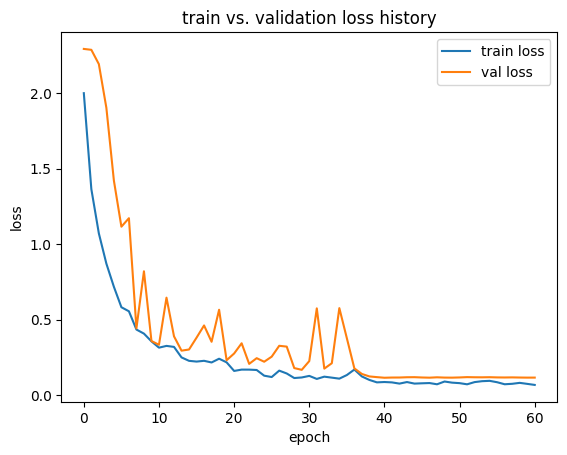

In [19]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Step 4. Test and evaluation

In this step, we define a `test()` function to make predictions on the test set.
Similarity to the `train()` function, the `test()` function is also slightly different from the previous session:
- The code is optimized for readability
- The data is moved to GPU if it's available

In [20]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device) # move data to GPU
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [21]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, model, loss_fn)
print(classification_report(test_label, test_pred))

test loss = 0.08026164397597313
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      0.97      0.99        35
           2       0.97      1.00      0.99        36
           3       0.94      1.00      0.97        29
           4       1.00      1.00      1.00        30
           5       0.97      0.93      0.95        40
           6       1.00      1.00      1.00        44
           7       0.95      1.00      0.97        39
           8       1.00      0.90      0.95        39
           9       0.93      0.98      0.95        41

    accuracy                           0.97       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.97      0.97       360



The recognized digit is: 2
The predicted probability is: 0.9998062


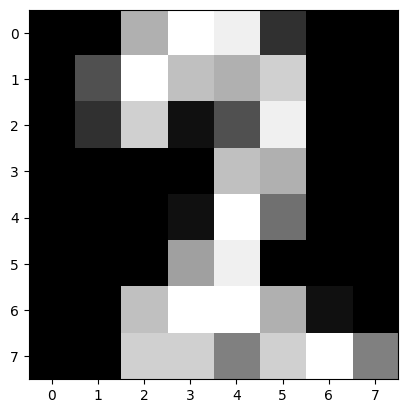

In [22]:
# display an example
plt.imshow(test_ds[0][0].numpy().reshape(8, 8), cmap = 'gray')
print('The recognized digit is:', test_pred[0])
print('The predicted probability is:', test_prob[0, test_pred[0]])

## Part 2. Try MNIST Dataset

In the previous part, we used the `sklearn` built-in dataset, which is small.

To release the potential of deep learning, we usually need a large dataset.

Therefore, we will use the PyTroch build-in MNIST dataset (70,000 samples) to see how the size of the dataset will change the whole process.

The main difference will the increasing training time.

### Step 1. Build the data pipeline

Instead of using `sklearn`, we use `trochvision.datasets.MNIST` to load the MNIST dataset and split it using `torchvision.utils.data.random_split`.

The PyTorch built-in MNIST dataset is already preprocessed, no need to perform feature scaling yourself.

The MNIST dataset is the same but a larger version of the dataset used in Part 1.

The image is stored as a $8\times8$ 2D array, no need to reshape.

You can find the PyTroch documentation [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) and more details from the [original source](http://yann.lecun.com/exdb/mnist/).

In [23]:
# load MNIST dataset
train_val_ds = datasets.MNIST(
    root = 'data', # store in the data folder
    train = True, # get the train part
    download = True,
    transform = transforms.ToTensor()
)
test_ds = datasets.MNIST(
    root = 'data', # store in the data folder
    train = False, # get the test part
    download = True,
    transform = transforms.ToTensor()
)
train_ds, val_ds = random_split(
    train_val_ds,
    [0.8, 0.2] # [train size, val size]
)

100%|██████████| 9912422/9912422 [00:03<00:00, 2759985.43it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 9901560.72it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2995744.29it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [25]:
# create the train and test data loaders
batch_size = 8192 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

The label of this hand-written digit is: 2


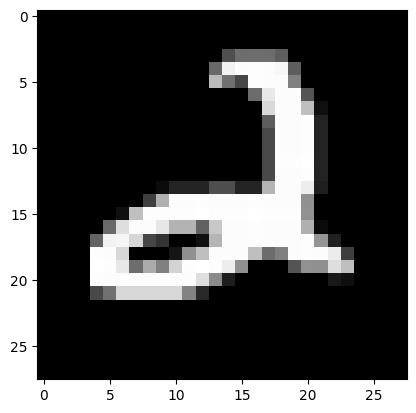

In [26]:
# display an example
plt.imshow(train_ds[0][0].numpy().reshape(28, 28), cmap = 'gray')
print('The label of this hand-written digit is:', train_ds[0][1])

### Step 2. Create the network

We can keep using the same network structure.

Here we create a new CNN instance, named as `mnist_model`.

In [27]:
# create the neural network
mnist_model = ImageClassifier(
    in_channels = train_ds[0][0].shape[0],
    n_labels = 10
).to(device)

### Step 3. Train the network

We can keep using the same `train()` function.

We will use a new optimizer (`torch.optim.Adam`) instead of (`torch.optim.SGD`).
- `Adam` is based on `SGD` but faster, it requires less epochs
- You can find the documentation [here](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
- Sometimes you may find `Adam` failed to reduce the loss, then you can try to switch back to `SGD`

Warning: If you find the training process is too slow on your computer, switch to Google Colab.
- Change runtime type to T4 GPU for GPU acceleration

In [28]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    mnist_model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 20
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 10
)

In [29]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    mnist_model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
mnist_model.load_state_dict(torch.load(saved_path))

Epoch 1: train loss = 1.969316, val loss = 11.534240, time consumed = 0:00:18
Model saved after epoch 1
Epoch 2: train loss = 0.934016, val loss = 3.946838, time consumed = 0:00:35
Model saved after epoch 2
Epoch 3: train loss = 0.570850, val loss = 1.738214, time consumed = 0:00:57
Model saved after epoch 3
Epoch 4: train loss = 0.381482, val loss = 2.105969, time consumed = 0:01:15
Epoch 5: train loss = 0.281695, val loss = 2.221324, time consumed = 0:01:34
Epoch 6: train loss = 0.222406, val loss = 1.364386, time consumed = 0:01:52
Model saved after epoch 6
Epoch 7: train loss = 0.188808, val loss = 0.981999, time consumed = 0:02:10
Model saved after epoch 7
Epoch 8: train loss = 0.158226, val loss = 0.453758, time consumed = 0:02:29
Model saved after epoch 8
Epoch 9: train loss = 0.143015, val loss = 0.355785, time consumed = 0:02:49
Model saved after epoch 9
Epoch 10: train loss = 0.126434, val loss = 0.155321, time consumed = 0:03:08
Model saved after epoch 10
Epoch 11: train los

KeyboardInterrupt: 

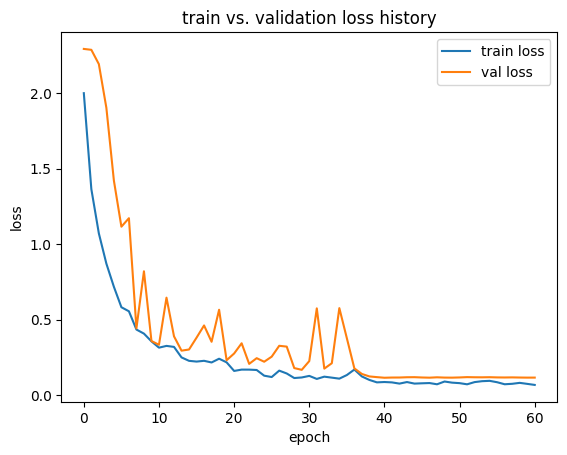

In [30]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Step 4. Test and evaluation

We can keep using the same `test()` function.

In [31]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, mnist_model, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred))

test loss = 0.08124731481075287
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



We can see the accuracy is further improved with the larger dataset.

This is because the larger dataset is more representative than a smaller one.

Sometimes you may have a CNN that behaves better on the smaller dataset. This may be because the CNN is not complex enough to fully capture the hidden patterns in the larger dataset, then you can try to increase the capacity of yout CNN.

The recognized digit is: 7
The predicted probability is: 0.99999976


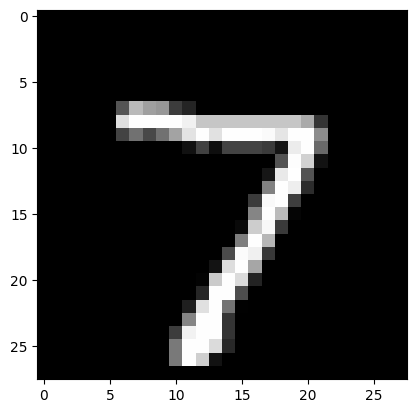

In [32]:
# display an example
plt.imshow(test_ds[0][0].numpy().reshape(28, 28), cmap = 'gray')
print('The recognized digit is:', test_pred[0])
print('The predicted probability is:', test_prob[0, test_pred[0]])